In [1]:
# 安装拓展包
pip install some_package --user

SyntaxError: invalid syntax (2261731898.py, line 2)

In [ ]:
# 查看当前kernel下已安装的包  list packages
!pip list --format=columns

In [6]:
!pip install --upgrade pip

Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 22.3.1
    Uninstalling pip-22.3.1:
      Successfully uninstalled pip-22.3.1


In [2]:
# 举例：安装sklearn某依赖库
!pip install mindspore

Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.2/947.2 MB 1.9 MB/s eta 0:00:0000:0100:03

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [1]:
!pip install -U scikit-learn

Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple/

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
# 根据实验报告要求完成实验，并提交完整版实验报告

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mindspore import nn, Tensor, ops
import mindspore
import random

def kmeans_pp(X, K, n_init=10):
    n_samples, n_features = X.shape
    best_labels = []
    best_centers = np.zeros((K, n_features))
    best_cost = np.inf
    for i in range(n_init):
        prev_loss = 0
        centers = np.zeros((K, n_features))
        #从数据点中均匀随机选择第一个中心
        centers[0] = X[np.random.choice(n_samples)]
        #使用k-means++算法选择剩余的中心点
        for i in range(1, K):
            #计算每个点到最近中心的距离
            distances = np.array([min([np.linalg.norm(x - c) for c in centers[:i]]) for x in X])
            #随机选择下一个中心，概率与距离的平方成正比
            probabilities = distances ** 2 / np.sum(distances ** 2)
            centers[i] = X[np.random.choice(n_samples, p=probabilities)]
        # 分配剩余数据点到最近的中心
        labels = []
        for x in X:
            distances = np.array([np.linalg.norm(x - c) for c in centers])
            labels.append(np.argmin(distances))
        # 计算当前分配的平方和损失
        loss = nn.MSELoss()(Tensor(X), Tensor(centers[labels]))
        if loss < best_cost:
                best_cost = loss
                best_labels = labels
                best_centers = centers
        # 迭代更新中心点
        while(abs(loss-prev_loss)/loss>0.01):
            prev_loss = loss
            for i in range(K):
                centers[i] = np.mean(X[np.array(labels) == i], axis=0)
            labels = []
            for x in X:
                distances = np.array([np.linalg.norm(x - c) for c in centers])
                labels.append(np.argmin(distances))
            loss = nn.MSELoss()(Tensor(X), Tensor(centers[labels]))

            # 保存最优结果
            if loss < best_cost:
                best_cost = loss
                best_labels = labels
                best_centers = centers
    return np.array(best_labels), best_centers, best_cost

def euclidDistance(x1, x2, sqrt_flag=True):
    res = np.sum((x1-x2)**2)
    if sqrt_flag:
        res = np.sqrt(res)
    return res

def calEuclidDistanceMatrix(X):
    X = np.array(X)
    S = np.zeros((len(X), len(X)))
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            S[i][j] = 1.0 * euclidDistance(X[i], X[j])
            S[j][i] = S[i][j]
    return S

def myKNN(S, k=5, sigma=1.0):
    N = len(S)
    A = np.zeros((N,N))

    for i in range(N):
        dist_with_index = zip(S[i], range(N))
        dist_with_index = sorted(dist_with_index, key=lambda x:x[0])
        neighbours_id = [dist_with_index[m][1] for m in range(k+1)] # xi's k nearest neighbours

        for j in neighbours_id: # xj is xi's neighbour
            A[i][j] = np.exp(-S[i][j]/2/sigma/sigma)
            A[j][i] = A[i][j] # mutually

    return A

def calLaplacianMatrix(adjacentMatrix):

    adjacentMatrix = Tensor(adjacentMatrix, mindspore.float32)
    # compute the Degree Matrix: D=sum(A)
    degreeMatrix = ops.reduce_sum(adjacentMatrix, 1)

    # compute the Laplacian Matrix: L=D-A
    laplacianMatrix = ops.diag(degreeMatrix) - adjacentMatrix

    # normailze
    # D^(-1/2) L D^(-1/2)
    sqrtDegreeMatrix = ops.diag(1.0 / (degreeMatrix ** (0.5)))
    return ops.dot(ops.dot(sqrtDegreeMatrix, laplacianMatrix), sqrtDegreeMatrix).asnumpy()

def spKmeans(X, k):
    distM = calEuclidDistanceMatrix(X)
    adjacentMatrix = myKNN(distM)
    laplacianMatrix = calLaplacianMatrix(adjacentMatrix)
    lam, V = np.linalg.eig(laplacianMatrix)
    lam = zip(lam, range(len(lam)))
    lam = sorted(lam, key=lambda x:x[0])
    H = np.vstack([V[:,i] for (v, i) in lam[:4]]).T
    H = np.asarray(H).astype(float)
    pred, centers, _ = kmeans_pp(H, k)
    return pred, centers

print("以上为谱聚类代码")


以上为谱聚类代码


In [4]:
#初始化聚类中心
def init_k_node(data,k):
    data =list(data)
    return random.sample(data,k)
#讲各节点分配给聚类中心
def get_clusters(data,k_centroids):
    cluster_dict =dict() #用来存储每个类别对应的节点信息
    k=len(k_centroids) #可获取设定的聚类个数
    labels = []
    for node in data:
        cluster_idx=-1 #设定初始类别为-1
        min_dis=float("inf") #设定初始聚类中心
        for idx in range(k): #计算节点同每个初始聚类中心的距离
            centroid=k_centroids[idx]
            distance =euclidDistance(node,centroid)
            if distance < min_dis:
                min_dis =distance
                cluster_idx=idx
                
        #存储每个类别包含的样本
        labels.append(cluster_idx)
        if cluster_idx not in cluster_dict.keys():
            cluster_dict[cluster_idx] = []
        cluster_dict[cluster_idx].append(node)
    return labels, cluster_dict

# 重新计算聚类中心
def get_centroids(cluster_dict):
    new_k_centroids=[]
    for cluster_idx in cluster_dict.keys():
        new_centroid = np.mean(cluster_dict[cluster_idx],axis=0)#每个类别中的均值
        new_k_centroids.append(new_centroid)
    return new_k_centroids
#计算各类间方差
def get_variance(centroids,cluster_dict):
    sum=0.0 #初始化均方误差为0
    for cluster_idx  in cluster_dict.keys():
        centroid = centroids[cluster_idx] #获取聚类中心
        distance= 0.0
        for node  in  cluster_dict[cluster_idx]:
            distance += euclidDistance(node,centroid)
        sum+=distance
    return sum
def kmeans(data, k):
    centroids=init_k_node(data,k) #获取初始聚类中心
    _, cluster_dict=get_clusters(data,centroids) #初始分类
    new_var=get_variance(centroids,cluster_dict) #计算初始聚类均方差
    old_var=1
    
    #设定条件，当两次聚类得误差小于某个值时，说明聚类基本稳定：
    while abs(new_var-old_var)>=0.00001:
        centroids =get_centroids(cluster_dict)
        labels, cluster_dict=get_clusters(data,centroids)
        old_var=new_var
        new_var=get_variance(centroids,cluster_dict)
        
    return labels, centroids,cluster_dict

print("以上为K-means聚类代码")

以上为K-means聚类代码


In [5]:
class DBscan:
    def __init__(self,eps,MinPts):
        self.eps = eps
        self.MinPts = MinPts
    
    def regionQuery(self,i,x):
        diff = i - x
        distances = np.sqrt(np.square(diff).sum(axis=1))
        #返回邻域点的索引
        return list(np.where(distances <= self.eps)[0])
    
    def fit(self,x):
        #初始标签为-1
        label = -1
        m =len(x)
        #初始化所有样本点所属的类别，定为-1
        cluster = [-1 for i in range(m)]
        #已访问样本点
        visited = []      
        for p in range(m):
            if p not in visited:
                NeighborPts = self.regionQuery(x[p],x)
                if len(NeighborPts) < self.MinPts:
                    #默认标记为-1，后面可能会被加入到其他的邻域内，成为一个密度可达点
                    continue
                else:
                    label += 1
                    cluster[p] = label
                    #列表NeighborPts是动态变化的，添加没有访问过的全部密度可达点，划分到一个簇
                    for p_1 in NeighborPts:
                        if p_1 not in visited:
                            visited.append(p_1)
                            Ner_NeighborPts = self.regionQuery(x[p_1],x)
                            if len(Ner_NeighborPts) >= self.MinPts:
                                for a in Ner_NeighborPts:
                                    if a not in NeighborPts:
                                        NeighborPts.append(a)
                            #同时把p_1的类别改为label
                            cluster[p_1] = label
        return cluster
print("以上是DBSCAN聚类的代码")

以上是DBSCAN聚类的代码


In [8]:
df = pd.read_csv('downloads/22861/car_price.csv')
# 使用af保存原始数据
af = df.copy()
# 以下各列指定数值进行转化
df['cylindernumber']=df.cylindernumber.replace({'two':2,'three':3,'four':4,'five':5,'six':6,'eight':8,'twelve':12})
df['doornumber']=df.doornumber.replace({'two':2,'four':4})

# 以下各列转为离散数字编码
# df['CarName'] = pd.Categorical(df['CarName']).codes
df['fueltype'] = pd.Categorical(df['fueltype']).codes
df['aspiration'] = pd.Categorical(df['aspiration']).codes
df['doornumber'] = pd.Categorical(df['doornumber']).codes
df['carbody'] = pd.Categorical(df['carbody']).codes
df['drivewheel'] = pd.Categorical(df['drivewheel']).codes
df['enginelocation'] = pd.Categorical(df['enginelocation']).codes
df['enginetype'] = pd.Categorical(df['enginetype']).codes
# df['cylindernumber'] = pd.Categorical(df['cylindernumber']).codes
df['fuelsystem'] = pd.Categorical(df['fuelsystem']).codes

nf = df.copy()
df.drop(columns=['CarName'], inplace=True)
df.drop(columns=['car_ID'], inplace=True)
# 去掉无关列

df = df.apply(lambda x:(x-np.min(x))/(np.max(x)-np.min(x)))
# 数据归一化
print('数据归一化后的df如下')
print(df)
data = np.array(list(df.to_numpy()))

数据归一化后的df如下
     symboling  fueltype  aspiration  doornumber  carbody  drivewheel  \
0          1.0       1.0         0.0         0.0     0.00         1.0   
1          1.0       1.0         0.0         0.0     0.00         1.0   
2          0.6       1.0         0.0         0.0     0.50         1.0   
3          0.8       1.0         0.0         1.0     0.75         0.5   
4          0.8       1.0         0.0         1.0     0.75         0.0   
..         ...       ...         ...         ...      ...         ...   
200        0.2       1.0         0.0         1.0     0.75         1.0   
201        0.2       1.0         1.0         1.0     0.75         1.0   
202        0.2       1.0         0.0         1.0     0.75         1.0   
203        0.2       0.0         1.0         1.0     0.75         1.0   
204        0.2       1.0         1.0         1.0     0.75         1.0   

     enginelocation  wheelbase  carlength  carwidth  ...  enginesize  \
0               0.0   0.058309   0.4134

In [110]:
#对数据进行描述性统计
print('描述性统计：')
df.describe()

描述性统计：


,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,...,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.566829,0.902439,0.180488,0.560976,0.653659,0.663415,0.014634,0.354419,0.491780,0.467317,...,0.248707,0.464808,0.564111,0.564483,0.196409,0.233821,0.398009,0.339431,0.388190,0.202540
std,0.249061,0.297446,0.385535,0.497483,0.214770,0.278085,0.120377,0.175562,0.184139,0.178767,...,0.157142,0.287601,0.193460,0.149332,0.248253,0.164767,0.194688,0.181726,0.181222,0.198323
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,1.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0.230321,0.376119,0.316667,...,0.135849,0.142857,0.435714,0.495238,0.100000,0.091667,0.265306,0.166667,0.236842,0.066283
50%,0.600000,1.000000,0.000000,1.000000,0.750000,0.500000,0.000000,0.303207,0.479104,0.433333,...,0.222642,0.714286,0.550000,0.580952,0.125000,0.195833,0.428571,0.305556,0.368421,0.128519
75%,0.800000,1.000000,0.000000,1.000000,0.750000,1.000000,0.000000,0.460641,0.626866,0.550000,...,0.301887,0.714286,0.742857,0.638095,0.150000,0.283333,0.551020,0.472222,0.473684,0.282632
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


箱线图：
Index(['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'price'],
      dtype='object')


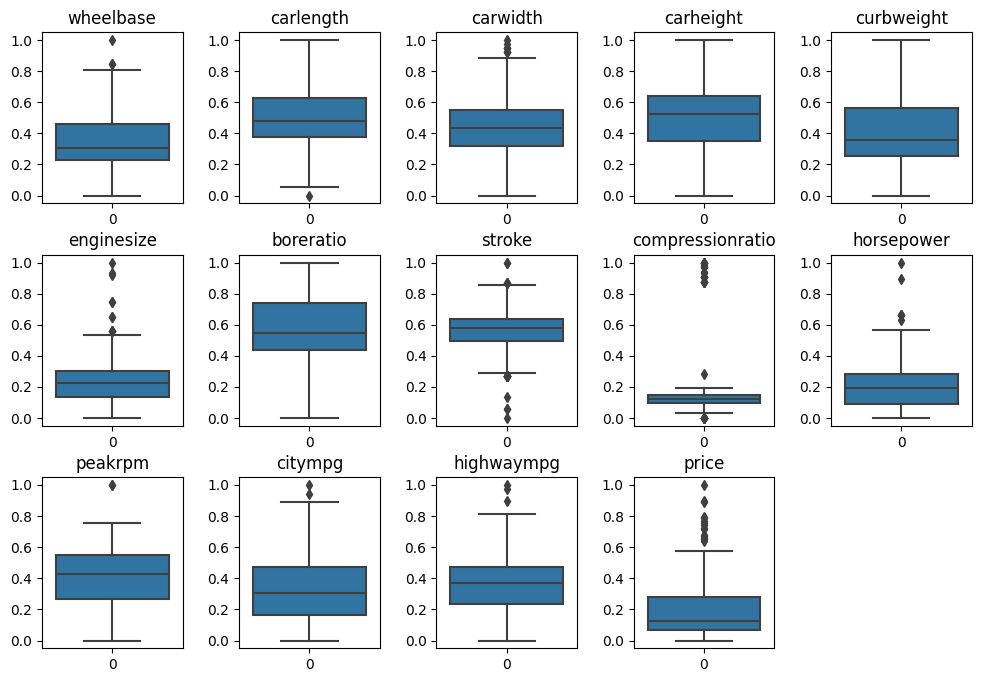

In [54]:
# 描绘数据集的箱线图，查看异常值
print('箱线图：')
# 提取类别变量的列名
cate_columns=['symboling','fueltype','aspiration','doornumber','carbody',
              'drivewheel','enginelocation','enginetype','fuelsystem','cylindernumber']
# 提取连续数值型数据的列名
num_cols=df.columns.drop(cate_columns)
print(num_cols)

# 绘制连续数值型数据的箱线图，检查异常值
import seaborn as sns

fig=plt.figure(figsize=(12,8))
i=1
for col in num_cols:
    ax=fig.add_subplot(3,5,i)
    sns.boxplot(data=df[col],ax=ax)
    i=i+1
    plt.title(col) 

plt.subplots_adjust(wspace=0.4,hspace=0.3)
plt.show()


In [9]:
# 模型评价指标计算
from sklearn.metrics import davies_bouldin_score

# Silhouette Coefficient Index

def get_silhouette_coefficient(X, labels):
    n_clusters = np.unique(labels).shape[0]
    s = []
    for k in range(n_clusters):  # 遍历每一个簇
        index = (labels == k)  # 取对应簇所有样本的索引
        x_in_cluster = X[index]  # 去对应簇中的所有样本
        for sample in x_in_cluster:  # 计算每个样本的轮廓系数
            a = ((sample - x_in_cluster) ** 2).sum(axis=1)
            a = np.sqrt(a).sum() / (len(a) - 1)  # 去掉当前样本点与当前样本点的组合计数
            nearest_cluster_id = None
            min_dist2 = np.inf
            for c in range(n_clusters):  # 寻找距离当前样本点最近的簇
                if k == c:
                    continue
                centroid = X[labels == c].mean(axis=0)
                dist2 = ((sample - centroid) ** 2).sum()
                if dist2 < min_dist2:
                    nearest_cluster_id = c
                    min_dist2 = dist2
            x_nearest_cluster = X[labels == nearest_cluster_id]
            b = ((sample - x_nearest_cluster) ** 2).sum(axis=1)
            b = np.sqrt(b).mean()
            s.append((b - a) / np.max([a, b]))
    return np.mean(s)

# Calinski-Harabasz Index

def get_calinski_harabasz(X, labels):
    n_samples = X.shape[0]
    n_clusters = np.unique(labels).shape[0]
    betw_disp = 0.  # 所有的簇间距离和
    within_disp = 0.  # 所有的簇内距离和
    global_centroid = np.mean(X, axis=0)  # 全局簇中心
    for k in range(n_clusters):  # 遍历每一个簇
        x_in_cluster = X[labels == k]  # 取当前簇中的所有样本
        centroid = np.mean(x_in_cluster, axis=0)  # 计算当前簇的簇中心
        within_disp += np.sum((x_in_cluster - centroid) ** 2)
        betw_disp += len(x_in_cluster) * np.sum((centroid - global_centroid) ** 2)
    return (1. if within_disp == 0. else
            betw_disp * (n_samples - n_clusters) /
            (within_disp * (n_clusters - 1.)))

# Davies-Bouldin Index
def get_davies_bouldin(X, labels):
    n_clusters = np.unique(labels).shape[0]
    centroids = np.zeros((n_clusters, len(X[0])), dtype=float)
    s_i = np.zeros(n_clusters)
    for k in range(n_clusters):  # 遍历每一个簇
        x_in_cluster = X[labels == k]  # 取当前簇中的所有样本
        centroids[k] = np.mean(x_in_cluster, axis=0)  # 计算当前簇的簇中心
        s_i[k] = euclidDistance(x_in_cluster, [centroids[k]]).mean()  #
    centroid_distances = euclidDistance(centroids)  # [K,K]
    combined_s_i_j = s_i[:, None] + s_i  # [K,k]
    centroid_distances[centroid_distances == 0] = np.inf
    scores = np.max(combined_s_i_j / centroid_distances, axis=1)
    return np.mean(scores)

print('以上为评价指标计算')
print('以下为三种方式的聚类')

以上为评价指标计算
以下为三种方式的聚类


In [23]:
# 谱聚类结果
for i in range(3, 8, 1):
    labels, centers = spKmeans(data, i)
    data_valid = data[labels!=-1]
    labels_valid = labels[labels!=-1]
    print(i)
    print(f"轮廓系数: {get_silhouette_coefficient(data_valid, labels_valid)}")
    print(f"方差比: {get_calinski_harabasz(data_valid, labels_valid)}")
    print(f"DB指数: {davies_bouldin_score(data_valid, labels_valid)}")
# # print(data_valid)

# print("谱聚类分类结果编码：")
# # print(labels)
# print(labels_valid)

3
轮廓系数: 0.22330531927590716
方差比: 31.627912161740678
DB指数: 1.2379185131658004
4
轮廓系数: 0.29433413927735
方差比: 54.11355341337559
DB指数: 1.2962807147962057
5
轮廓系数: 0.26200614679833556
方差比: 52.28216137638234
DB指数: 1.2593949823877932
6
轮廓系数: 0.1980200303296798
方差比: 46.13655933094679
DB指数: 1.5767317597634893
7
轮廓系数: 0.18415245889178541
方差比: 38.0339921848393
DB指数: 1.8776266267218413


In [20]:
# kmeans聚类结果
data_valid = data[labels_v!=-1]
for i in range(3, 8, 1):
    kmeanLabels, _, _=kmeans(data, i)
    data_v = data[kmeanLabels!=-1]
    labels_v = np.array(kmeanLabels)
    print(i)
    print(f"轮廓系数: {get_silhouette_coefficient(data_valid, labels_v)}")
    print(f"方差比: {get_calinski_harabasz(data_valid, labels_v)}")
    print(f"DB指数: {davies_bouldin_score(data_valid, labels_v)}")


3
轮廓系数: 0.23649700104746887
方差比: 48.99285684505013
DB指数: 1.520077462756431
4
轮廓系数: 0.2778937832248334
方差比: 64.0746670910635
DB指数: 1.2215406656235248
5
轮廓系数: 0.27788345324984803
方差比: 50.466037183837805
DB指数: 1.3137235317824438
6
轮廓系数: 0.28977079267433503
方差比: 60.525965645295926
DB指数: 1.2733599457635512
7
轮廓系数: 0.24625548362159624
方差比: 44.51234843563367
DB指数: 1.2238121883104838


In [29]:
data_valid = data[labels_v!=-1]
eps = 1
for i in range(3, 12, 1):
    Dbscan =DBscan(eps,MinPts=i)
    y_pred = Dbscan.fit(data)
    dblabels = np.array(y_pred)+1
    print(i)
    print(f"轮廓系数: {get_silhouette_coefficient(data_valid, dblabels)}")
    print(f"方差比: {get_calinski_harabasz(data_valid, dblabels)}")
    print(f"DB指数: {davies_bouldin_score(data_valid, dblabels)}")

3
轮廓系数: 0.30503949842514166
方差比: 34.28725649827263
DB指数: 1.3058235918797383
4
轮廓系数: 0.31493746038598275
方差比: 36.68131737213992
DB指数: 1.4775440750332287
5
轮廓系数: 0.31493746038598275
方差比: 36.68131737213992
DB指数: 1.4775440750332287
6
轮廓系数: 0.3364998559683405
方差比: 37.218445899468854
DB指数: 1.786691696474689
7
轮廓系数: 0.3364998559683405
方差比: 37.218445899468854
DB指数: 1.786691696474689
8
轮廓系数: 0.3277308452715997
方差比: 36.71132066427044
DB指数: 1.7579078008205054
9
轮廓系数: 0.3222730670068356
方差比: 39.45567230028974
DB指数: 1.9652897579974877
10
轮廓系数: 0.3222730670068356
方差比: 39.45567230028974
DB指数: 1.9652897579974877
11
轮廓系数: 0.3222730670068356
方差比: 39.45567230028974
DB指数: 1.9652897579974877


In [34]:
data_valid = data[labels_v!=-1]
MinPts=6
eps = 0.4
for i in range(3, 12, 1):
    eps+=0.1
    Dbscan =DBscan(eps,MinPts)
    y_pred = Dbscan.fit(data)
    dblabels = np.array(y_pred)+1
    print(eps)
    print(f"轮廓系数: {get_silhouette_coefficient(data_valid, dblabels)}")
    print(f"方差比: {get_calinski_harabasz(data_valid, dblabels)}")
    print(f"DB指数: {davies_bouldin_score(data_valid, dblabels)}")

0.5
轮廓系数: 0.014146502326817736
方差比: 13.863052486412245
DB指数: 1.7793444883412952
0.6
轮廓系数: 0.14569555798769873
方差比: 22.57413410955074
DB指数: 1.7368174037424464
0.7
轮廓系数: 0.2779884730110242
方差比: 34.29713010737719
DB指数: 1.8116989167401925
0.7999999999999999
轮廓系数: 0.3171713801636255
方差比: 31.148140923202583
DB指数: 1.867029821911787
0.8999999999999999
轮廓系数: 0.34309713558982713
方差比: 35.86087305826112
DB指数: 1.8585343953354405
0.9999999999999999
轮廓系数: 0.3364998559683405
方差比: 37.218445899468854
DB指数: 1.786691696474689
1.0999999999999999
轮廓系数: 0.27327001366305015
方差比: 23.934237716110363
DB指数: 1.3673930293575982
1.2
轮廓系数: 0.2617964219452193
方差比: 24.437648207399654
DB指数: 1.0406174868151987
1.3
轮廓系数: nan
方差比: 21.32687095059509
DB指数: 1.013522747039137


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


In [39]:
# 谱聚类结果
labels, centers = spKmeans(data, 4)
data_valid = data[labels!=-1]
labels_valid = labels[labels!=-1]
print(labels_valid)

[1 1 1 2 2 1 2 2 2 0 1 2 1 2 2 2 1 2 1 1 2 1 1 0 2 2 2 0 2 0 1 1 1 1 1 2 2
 1 1 2 2 2 1 2 1 2 1 2 2 1 1 1 1 2 2 1 1 1 1 1 2 1 2 3 2 2 3 3 3 3 3 2 1 2
 1 0 1 1 1 0 0 1 0 0 0 2 2 2 2 1 3 1 2 2 1 1 2 2 1 2 2 2 2 2 1 0 1 2 3 2 3
 2 3 2 3 2 3 2 1 0 2 2 2 2 0 1 1 1 1 1 2 1 1 2 1 2 0 2 1 1 1 2 2 2 2 2 2 2
 2 2 1 1 2 2 2 2 2 2 3 3 2 2 2 1 1 1 1 1 1 1 1 1 1 2 3 2 2 2 1 1 2 2 3 1 3
 2 2 3 2 1 1 2 3 2 2 2 2 2 2 2 2 2 2 3 2]


In [37]:
# kmeans
kmeanLabels, _, _=kmeans(data, 4)
data_v = data[kmeanLabels!=-1]
labels_v = np.array(kmeanLabels)
print(labels_v)

[0 0 0 1 1 0 2 2 2 0 0 1 0 2 2 2 0 2 3 3 1 3 3 0 1 1 1 0 1 0 3 3 3 3 3 1 1
 3 3 1 1 1 3 1 3 1 0 2 2 0 3 3 3 1 1 0 0 0 0 3 1 3 1 1 1 2 2 2 2 2 2 2 0 2
 0 0 3 3 3 0 0 3 0 0 0 1 1 1 1 3 3 3 1 1 3 3 1 1 3 1 1 2 2 2 0 0 0 2 2 2 2
 2 2 2 2 2 2 2 3 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0 2 3 3 3 1 1 1 1 1 1 1
 1 1 3 3 1 1 1 1 1 1 1 1 1 1 1 3 3 0 0 0 0 0 0 0 0 1 2 1 1 1 0 0 2 2 3 3 1
 1 1 1 1 0 0 1 2 1 2 2 2 2 2 2 2 2 2 2 2]


In [43]:
# DBSCAN聚类
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.9, min_samples=6).fit(data)
dlabels = db.labels_ + 1
print('以下为使用sklearn的DBSCAN聚类结果')
print(dlabels)

以下为使用sklearn的DBSCAN聚类结果
[1 1 1 2 2 1 2 2 5 0 1 2 1 2 2 2 1 2 1 1 2 1 1 3 2 2 2 3 2 3 1 1 1 1 1 2 2
 1 1 2 2 2 1 2 1 2 1 2 2 0 1 1 1 2 2 1 1 1 1 1 2 1 2 0 2 2 0 4 4 0 4 2 1 2
 0 3 1 1 1 3 3 1 3 3 3 2 2 0 2 1 0 1 2 2 1 1 2 2 1 2 2 2 2 2 1 3 1 2 4 2 4
 2 4 2 4 2 4 5 1 3 2 2 2 2 3 1 0 0 0 0 2 1 1 2 1 2 3 5 1 1 1 2 2 2 2 0 2 2
 2 0 1 1 2 2 2 2 2 2 0 0 2 2 2 1 1 1 1 1 1 1 1 1 1 2 4 2 2 2 1 1 2 2 0 1 0
 2 2 4 2 1 1 2 4 2 2 2 2 2 5 5 2 5 2 4 5]


In [35]:
Dbscan =DBscan(eps=0.9,MinPts=6)
y_pred = Dbscan.fit(data)
dblabels = np.array(y_pred)+1
print('以下为手写DBSCAN聚类结果')
print(dblabels)


以下为手写DBSCAN聚类结果
[1 1 1 2 2 1 2 2 5 0 1 2 1 2 2 2 1 2 1 1 2 1 1 3 2 2 2 3 2 3 1 1 1 1 1 2 2
 1 1 2 2 2 1 2 1 2 1 2 2 0 1 1 1 2 2 1 1 1 1 1 2 1 2 0 2 2 0 4 4 0 4 2 1 2
 0 3 1 1 1 3 3 1 3 3 3 2 2 0 2 1 0 1 2 2 1 1 2 2 1 2 2 2 2 2 1 3 1 2 4 2 4
 2 4 2 4 2 4 5 1 3 2 2 2 2 3 1 0 0 0 0 2 1 1 2 1 2 3 5 1 1 1 2 2 2 2 0 2 2
 2 0 1 1 2 2 2 2 2 2 0 0 2 2 2 1 1 1 1 1 1 1 1 1 1 2 4 2 2 2 1 1 2 2 0 1 0
 2 2 4 2 1 1 2 4 2 2 2 2 2 5 5 2 5 2 4 5]


In [40]:
print("谱聚类结果评价")
print(f"轮廓系数: {get_silhouette_coefficient(data_valid, labels_valid)}")
print(f"方差比: {get_calinski_harabasz(data_valid, labels_valid)}")
print(f"DB指数: {davies_bouldin_score(data_valid, labels_valid)}")

谱聚类结果评价
轮廓系数: 0.29433413927735
方差比: 54.113553413375605
DB指数: 1.2962807147962057


In [41]:
print("Kmeans聚类结果评价")
data_valid = data[labels_v!=-1]
print(f"轮廓系数: {get_silhouette_coefficient(data_valid, labels_v)}")
print(f"方差比: {get_calinski_harabasz(data_valid, labels_v)}")
print(f"DB指数: {davies_bouldin_score(data_valid, labels_v)}")

Kmeans聚类结果评价
轮廓系数: 0.2562871097363027
方差比: 59.59989055035303
DB指数: 1.427859691736306


In [44]:
print("第三方库DBSCAN聚类结果评价")
print(f"轮廓系数: {get_silhouette_coefficient(data_valid, dlabels)}")
print(f"方差比: {get_calinski_harabasz(data_valid, dlabels)}")
print(f"DB指数: {davies_bouldin_score(data_valid, dlabels)}")

第三方库DBSCAN聚类结果评价
轮廓系数: 0.34309713558982713
方差比: 35.86087305826112
DB指数: 1.8585343953354405


In [42]:
print("手写DBSCAN聚类结果评价")
print(f"轮廓系数: {get_silhouette_coefficient(data_valid, dblabels)}")
print(f"方差比: {get_calinski_harabasz(data_valid, dblabels)}")
print(f"DB指数: {davies_bouldin_score(data_valid, dblabels)}")
print('与第三方库结果相近')

手写DBSCAN聚类结果评价
轮廓系数: 0.34309713558982713
方差比: 35.86087305826112
DB指数: 1.8585343953354405
与第三方库结果相近


In [45]:
print('根据聚类结果评估指标，谱聚类结果表现更佳')

根据聚类结果评估指标，谱聚类结果表现更佳


四类的ID:

No.0 [ 10  24  28  30  76  80  81  83  84  85 106 120 125 137]

No.1 [  1   2   3   6  11  13  17  19  20  22  23  31  32  33  34  35  38  39
  43  45  47  50  51  52  53  56  57  58  59  60  62  73  75  77  78  79
  82  90  92  95  96  99 105 107 119 126 127 128 129 130 132 133 135 139
 140 141 151 152 164 165 166 167 168 169 170 171 172 173 179 180 184 190
 191]

No.2 [  4   5   7   8   9  12  14  15  16  18  21  25  26  27  29  36  37  40
  41  42  44  46  48  49  54  55  61  63  65  66  72  74  86  87  88  89
  93  94  97  98 100 101 102 103 104 108 110 112 114 116 118 121 122 123
 124 131 134 136 138 142 143 144 145 146 147 148 149 150 153 154 155 156
 157 158 161 162 163 174 176 177 178 181 182 186 187 189 192 194 195 196
 197 198 199 200 201 202 203 205]

No.3 [ 64  67  68  69  70  71  91 109 111 113 115 117 159 160 175 183 185 188
 193 204]

四类的产品名:

No.0 ['audi 5000s (diesel)', 'dodge d200', 'dodge coronet custom', 'dodge coronet custom (sw)', 'mercury cougar', 'mitsub

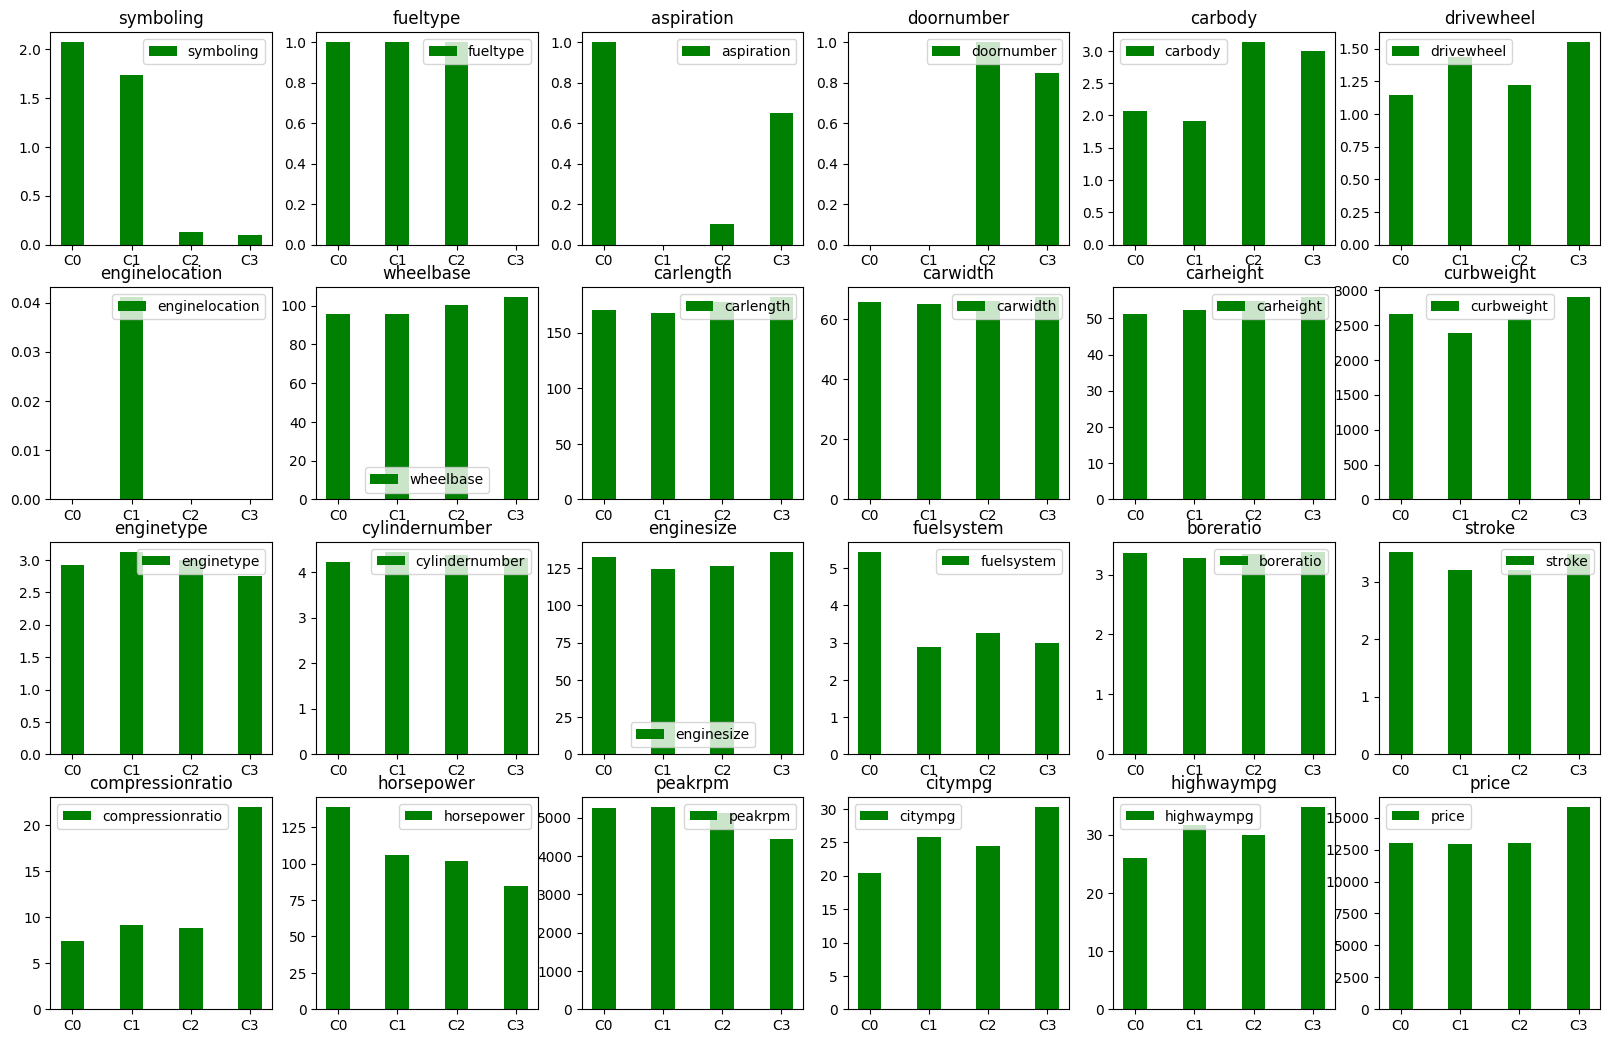

In [48]:
XLabel = ['C0', 'C1', 'C2', 'C3']
UselessColumn = ['car_ID', 'CarName']
# Car = pd.read_csv('car_price.csv')
# labels_valid = dblabels
Car = nf
Car = Car.copy().iloc[labels!=-1, :]
CarCluster = pd.concat([Car, pd.DataFrame(labels_valid)], axis=1)
CarCluster.rename({0:'Class'}, axis=1, inplace=True)
CategoryColumn = CarCluster.select_dtypes(include = 'object').columns

print('四类的ID:')
print()
for i in range(4):
    label = CarCluster.loc[CarCluster['Class']==i]
    da = np.array(list(label['car_ID'].to_numpy()))
    print("No.{}".format(i), da)
    print()
print('四类的产品名:')
print()
for i in range(4):
    label = CarCluster.loc[CarCluster['Class']==i]
    da = list(label['CarName'].to_numpy())
    print("No.{}".format(i), da)
    print()

print("每一类的平均特征如下")
# Mean = CarCluster.drop(UselessColumn, axis=1).drop(CategoryColumn, axis=1).groupby('Class').mean()
Mean = CarCluster.drop(UselessColumn, axis=1).groupby('Class').mean()
plt.figure(figsize=(20, 16))
n = 1
for i in Mean.columns:
    plt.subplot(5, 6, n)
    X = list(range(len(XLabel)))
    plt.bar(X, Mean[i], width = 0.4, label = i, tick_label = XLabel, fc = 'green')
    plt.title(i)
    n += 1
    plt.legend()
plt.show()

In [49]:
print('查看特指车名‘vokswagen’车型的聚类集群')
d=CarCluster.loc[:,['car_ID','CarName','Class']]
print(d.loc[d['CarName'].str.contains("vokswagen")])


查看特指车名‘vokswagen’车型的聚类集群
     car_ID           CarName  Class
182     183  vokswagen rabbit      3


In [50]:
print('查看特指车名为‘vokswagen’车型的竞品车型（分类0的所有车型）')
compe = pd.concat([af, pd.DataFrame(labels_valid)], axis=1).loc[CarCluster['Class']==3]

查看特指车名为‘vokswagen’车型的竞品车型（分类0的所有车型）


In [51]:
pd.concat([af, pd.DataFrame(labels_valid)], axis=1).loc[CarCluster['Class']==3]

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,0
63,64,0,mazda glc deluxe,diesel,std,four,sedan,fwd,front,98.8,...,idi,3.39,3.39,22.7,64,4650,36,42,10795.0,3
66,67,0,mazda rx-7 gs,diesel,std,four,sedan,rwd,front,104.9,...,idi,3.43,3.64,22.0,72,4200,31,39,18344.0,3
67,68,-1,buick electra 225 custom,diesel,turbo,four,sedan,rwd,front,110.0,...,idi,3.58,3.64,21.5,123,4350,22,25,25552.0,3
68,69,-1,buick century luxus (sw),diesel,turbo,four,wagon,rwd,front,110.0,...,idi,3.58,3.64,21.5,123,4350,22,25,28248.0,3
69,70,0,buick century,diesel,turbo,two,hardtop,rwd,front,106.7,...,idi,3.58,3.64,21.5,123,4350,22,25,28176.0,3
70,71,-1,buick skyhawk,diesel,turbo,four,sedan,rwd,front,115.6,...,idi,3.58,3.64,21.5,123,4350,22,25,31600.0,3
90,91,1,nissan gt-r,diesel,std,two,sedan,fwd,front,94.5,...,idi,2.99,3.47,21.9,55,4800,45,50,7099.0,3
108,109,0,peugeot 304,diesel,turbo,four,sedan,rwd,front,107.9,...,idi,3.70,3.52,21.0,95,4150,28,33,13200.0,3
110,111,0,peugeot 504,diesel,turbo,four,wagon,rwd,front,114.2,...,idi,3.70,3.52,21.0,95,4150,25,25,13860.0,3
112,113,0,peugeot 604sl,diesel,turbo,four,sedan,rwd,front,107.9,...,idi,3.70,3.52,21.0,95,4150,28,33,16900.0,3


查看竞品车型的特征分布


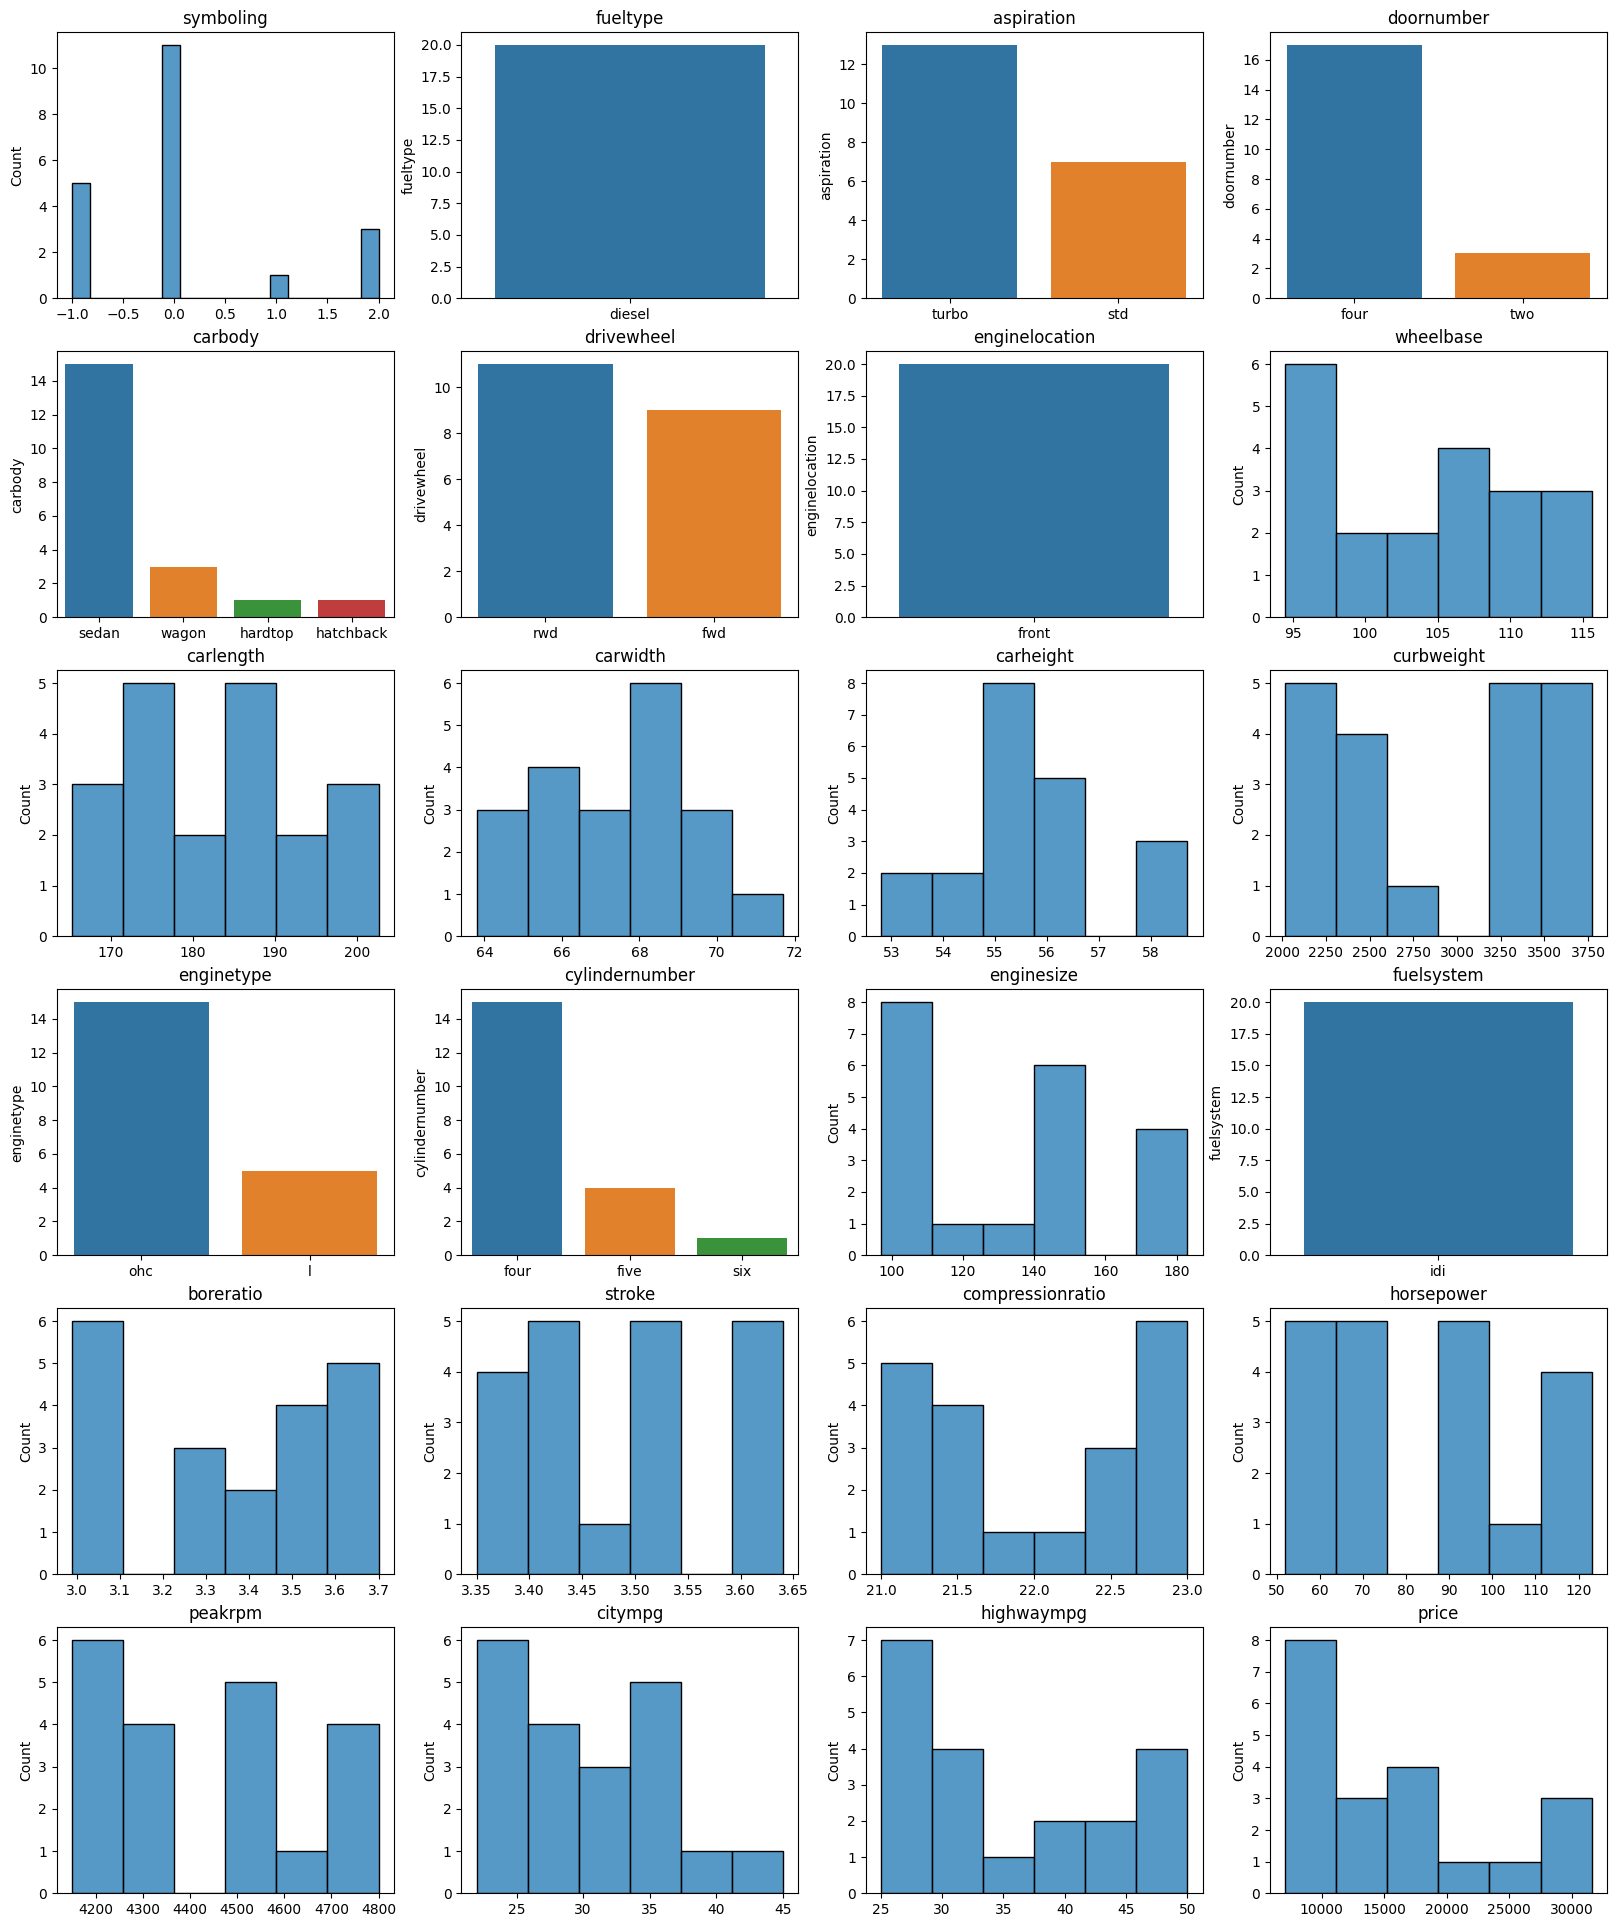

In [58]:
print('查看竞品车型的特征分布')
df0_1=compe.drop(['car_ID','CarName',0],axis=1)

#查看集群0的车型所有特征分布
fig=plt.figure(figsize=(20,20))
i=1
for c in df0_1.columns:
    ax=fig.add_subplot(7,4,i)
    if df0_1[c].dtypes=='int' or df0_1[c].dtypes=='float':
        sns.histplot(df0_1[c],ax=ax)
    else:
        sns.barplot(x=df0_1[c].value_counts().index,y=df0_1[c].value_counts(),ax=ax)
    i=i+1
    plt.xlabel('')
    plt.title(c)  
plt.subplots_adjust(top=1.2)


plt.show()